#### This notebook is a little chaotic, but I was messing around a little bit with the different ways that approaches and other heuristics of prey capture are defined because I'm convinced all of my capture times are wrong, ran into a few issues with approaches not being defined correctly, fixed that but now my ranges seem off. Overall goal is to find a more robust way to define if a capture occurs or not, because my pet theory currently is that some mess of that is why I have little to no effect in my data

In [3]:
import prey_capture_python as preycap
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy import interpolate
# from scipy import signal

In [4]:
## Test file that I was running this on where I ran into most of the issues, this maps it to my folder on KittyCC but all of the data are on ionas rn
file='/Volumes/molly/2022-02-24_11-29-56_mouse-0894/Sky_mouse-0894_2022-02-24T11_29_56DLC_dlcrnetms5_optopreycapFeb16shuffle1_150000_el_filtered.csv'

In [4]:
file

'/Volumes/molly/2022-02-24_11-29-56_mouse-0894/Sky_mouse-0894_2022-02-24T11_29_56DLC_dlcrnetms5_optopreycapFeb16shuffle1_150000_el_filtered.csv'

#### I'm not using preycap.extract_points (or geometries etc) in this notebook because I've been messing around with stuff in those functions that are defined in this notebook so ive just defined them inside here

In [9]:
mouse_xy, cricket_p, cricket_xy, rear_xy, lear_xy, headbase_xy=extract_points(file, ['Rear','Lear', 'anteriorC', 'posteriorC', 'headbase'], startonly=False)

In [10]:
mouse_xy[1]

array([35.27098101, 35.27787975, 35.30689873, ..., 61.51256329,
       61.48572785, 61.45708861])

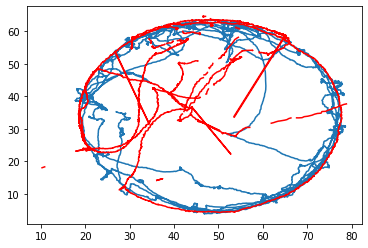

In [11]:
plt.plot(mouse_xy[0], mouse_xy[1])
plt.plot(cricket_xy[0], cricket_xy[1], color='r')

In [73]:
print(cricket_xy)
np.shape(cricket_xy)

[array([nan, nan, nan, ..., nan, nan, nan]), array([nan, nan, nan, ..., nan, nan, nan])]


(2, 30017)

In [10]:
dist, cricket_spd, mouse_spd, az= geometries(mouse_xy, cricket_xy, rear_xy, lear_xy, headbase_xy, cricket_p)

NameError: name 'approach' is not defined

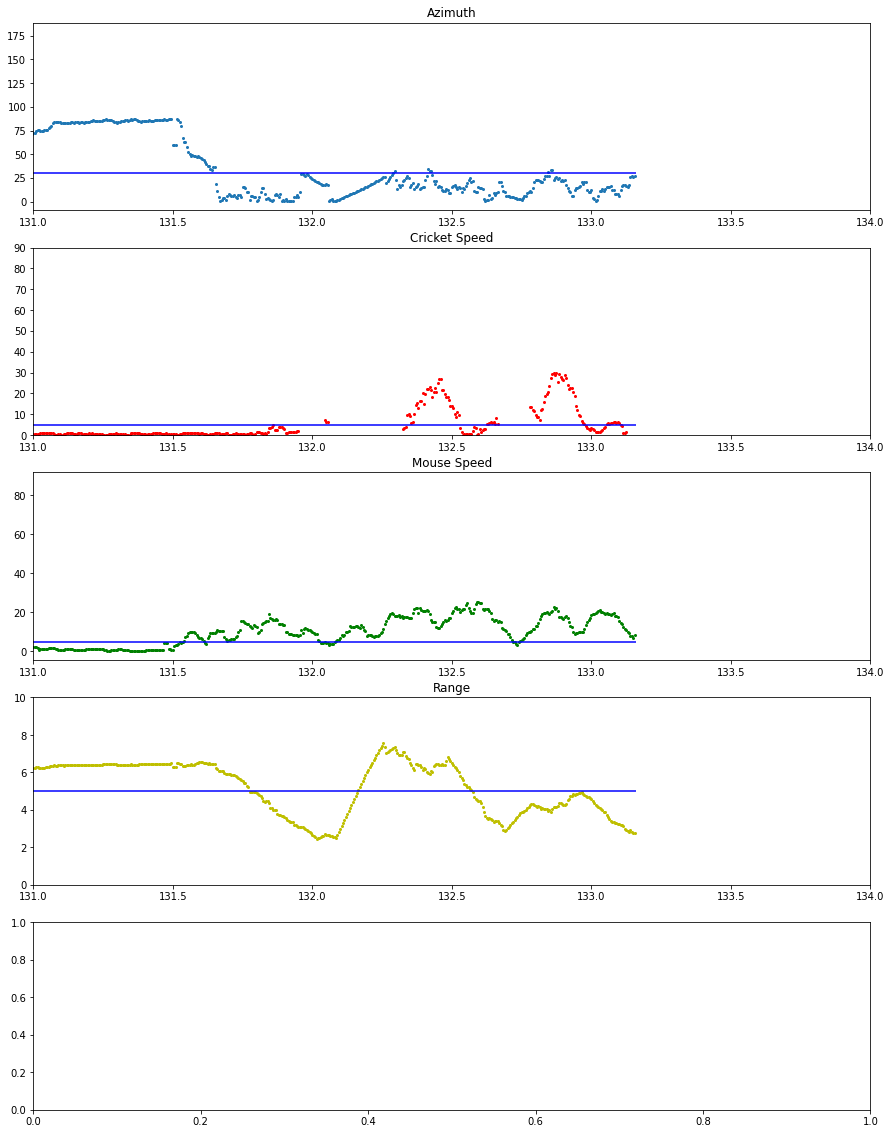

In [11]:
# plt.plot(mouse_spd)
fr=200
fig=plt.figure(figsize=(15,20))
ax1,ax2,ax3,ax4, ax5=fig.subplots(5,1)
ax1.plot(np.arange(0,len(az))/200,az, linestyle='', marker='o', markersize=2)
ax1.hlines(y=30, xmin=0,xmax=len(az)/fr, color='b')
ax1.set_title('Azimuth')
ax1.set_xlim(131,134)
# ax1.set_xlim(0,len(az)/fr)
# ax1.set_xticks(np.arange(0,len(az)/fr,10))
# ax1.hlines(y=-30, xmin=0,xmax=6000/200,color='b')
ax2.plot(np.arange(0,len(cricket_spd))/200,cricket_spd, linestyle='', marker='o', markersize=2, color='r')
ax2.hlines(y=5, xmin=0,xmax=len(cricket_spd)/fr,color='b')
ax2.set_title('Cricket Speed')
ax2.set_ylim(0,90)
ax2.set_xlim(131,134)
# ax2.set_xlim(0,len(cricket_spd)/fr)
# ax2.set_xticks(np.arange(0,len(cricket_spd)/fr,10))
ax3.plot(np.arange(0,len(mouse_spd))/200,mouse_spd, linestyle='', marker='o', markersize=2, color='g')
ax3.hlines(y=5, xmin=0,xmax=len(mouse_spd)/fr,color='b')
ax3.set_xlim(131,134)
ax3.set_title('Mouse Speed')
# ax3.set_xlim(0,len(mouse_spd)/fr)
# ax3.set_xticks(np.arange(0,len(mouse_spd)/fr,10))
ax4.plot(np.arange(0,len(dist))/fr,dist, linestyle='', marker='o', markersize=2, color='y')
ax4.set_xlim(131,134)
ax4.set_ylim(0,10)
ax4.set_title('Range')
ax4.hlines(y=5, xmin=0,xmax=len(dist)/fr,color='b')
# ax4.set_xlim(0,len(dist)/fr)
# ax4.set_xticks(np.arange(0,len(dist)/fr,10))
# ax3.set_xlim(6,25)
ax5.plot(np.arange(0,len(approach))/fr,approach, color='black')
ax5.set_title('Approaches')
ax5.set_xlim(131,134)
# ax5.set_xlim(0,len(dist)/fr)
# ax5.set_xticks(np.arange(0,len(dist)/fr,10))
sns.despine()

### looking at the above plots, the last range value that should be pulled is less than 5 (this is the cutoff i'm using to say something is an intercept/ capture) but if I have the code print the last value for range, it says is like ~6.5. I think there is some sort of indexing error going on, because using the relentlesspositivity function reindexes things to only include periods where the cricket is there, and I thought I fixed it so everything was being indexed the same way, but not sure if I did or not.

In [13]:
approach, captureT, freqapproach, timetoapproach, timetointercept, prob_inter, prob_capture =preycap_metrics(cricket_xy, cricket_p, dist, mouse_spd, az,oldmodel=False)

150.085


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [62]:
dist[26329]

6.432781151462668

In [58]:
len(dist)

26632

In [35]:
captureT

133.16

In [36]:
freqapproach

0.08661758336942399

In [37]:
timetoapproach

1.02

In [38]:
prob_inter

0.16666666666666666

In [39]:
prob_capture

0.5

In [40]:
timetointercept

5.715

In [6]:
import pandas as pd
import numpy as np

def extract_points(file, bodyparts, fr=200, pix2cm=15.8, thresh=0.7, startonly=False ):
    '''
    function to extract mouse and cricket xy positions from DLC output csv
    will also get the likelihood values for cricket positions
    can be adapted later to add extraction of likelihood for the mouse

    Args:
        file (str): filename/ path to the DLC output
        bodyparts (list): list of the bodypart labels from DLC you need
            added as an input since names vary across models
        fr (int): framerate of videos, default=200
        pix2cm (int): conversion from pixels to cm, default=14.5 (needs to be checked)
        thresh (int): threshold for likelihood values, default=0.7


    Returns:
        mouse_xy: xy coordinates for the mouse across the trial
        cricket_xy: xy coordinates for the cricket across trial, cricket_xy is filtered to remove points with low likelihood
        cricket_p: likelihood values of cricket points

    '''
    #set the constant values that will be used throughout
    #load relevant dlc points from the csv, limits the amount you have to work with
    data=pd.read_csv(file, skiprows=[0,1], header=[0,1])
    if startonly==False:
        data=data.loc[:,bodyparts]
    else:
        data=data.loc[:,bodyparts]
        data=data.iloc[0:(120*fr)]

    #create 2d array for mouse xy coordinates
    #right now indexing df depends on order of your bodyparts lists, find a better way to deal with this
    rear_x=data[bodyparts[0],'x'].to_numpy()
    rear_y=data[bodyparts[0],'y'].to_numpy()

    lear_x=data[bodyparts[1],'x'].to_numpy()
    lear_y=data[bodyparts[1],'y'].to_numpy()

    rear_xy=np.asarray([rear_x,rear_y])
    lear_xy=np.asarray([lear_x,lear_y])
    
    headbase_x=data[bodyparts[4],'x'].to_numpy()
    headbase_y=data[bodyparts[4],'y'].to_numpy()
    headbase_xy=np.asarray([headbase_x,headbase_y])/pix2cm

    mouse_xy=0.5*(rear_xy+lear_xy)/pix2cm

    #extract cricket likelihood and xy coordinates, same indexing issue
    cricket_p=(data[bodyparts[2],'likelihood'].to_numpy()+data[bodyparts[3],'likelihood'].to_numpy())/2
    cricket_x=(data[bodyparts[2],'x'].to_numpy()+data[bodyparts[3],'x'].to_numpy())/(2*pix2cm)
    cricket_y=(data[bodyparts[2],'y'].to_numpy()+data[bodyparts[3],'y'].to_numpy())/(2*pix2cm)

    thresh_cricket_x=cricket_x.copy()
    thresh_cricket_x[cricket_p<thresh]=np.nan
    thresh_cricket_y=cricket_y.copy()
    thresh_cricket_y[cricket_p<thresh]=np.nan

    cricket_xy=[thresh_cricket_x, thresh_cricket_y]

    return mouse_xy, cricket_p, cricket_xy, rear_xy, lear_xy, headbase_xy


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
from scipy import interpolate
from scipy import signal
from typing import List, Union

def relentless_positivity(df: pd.DataFrame, column:str, window: int = 20, threshold: float = 0.95,tolist:bool = True) -> Union[List[List[int]], np.ndarray]:
    """
    Find ranges where column is above threshold for #window number of rows

    Returns:
        List of Lists indicating the start and end of positive ranges
    """
    inds=np.where(df[column].rolling(window).sum()>=threshold*window)[0]
    starts=inds[np.diff(inds, prepend=-1)!=1]-window+1
    ends=inds[np.diff(inds, append=-1)!=1]
    periods=np.column_stack([starts, ends])
    if tolist:
        return periods.tolist()
    else:
        return periods

def preycap_metrics(cricket_xy, cricket_p, range, mouse_spd, az, fr=200, oldmodel=False):
        '''
        function to calculate basic metrics of prey capture behavior
        decent first pass look at if there are differences between conditions

        Arguments:
            cricket_xy (:class:`numpy.ndarray`): thresholded cricket xy coordinates
            cricket_p (:class:`numpy.ndarray`): cricket likelihoods
            range (:class:`numpy.ndarray`): distance between mouse and cricket
            mouse_spd (:class:`numpy.ndarray`): mouse speed (not velocity)
            az (:class:`numpy.ndarray`): angle between mouse's head and cricket
            fr (int): framerate of videos, default=200
            oldmodel (boolean): flag to mark cricket likelihood is bad, default=False

        Returns:
            captureT (int): time to capture the cricket --indication of start and end need to be changed
            latency (int): time to the first approach
            freqapproach (int): frequency of initiating approaches
            p_intercept (int): probability of intercepting given an approach
            p_capture (int): probability of capturing given intercepting
        '''
        #calculate the time to capture, right now running with a new, higher threshold than other calculations
        #have if/else statement so that if new models in the future fix things but we don't want to re run old data
        newthresh=0.9
        movieT=len(cricket_p)/fr
        print(movieT)
        if oldmodel==True:
            start2end=np.where(cricket_p>newthresh)[0]
            captureT=(start2end[-1]-start2end[0])/fr
        else:
            df = pd.DataFrame({'data':cricket_p})
            periods = relentless_positivity(df, 'data')
            start=np.min(periods)
            print(start)
            end=np.max(periods)
            print(end)
            print(end-start)
            captureT=(end-start)/fr
            print(captureT)
        if captureT.size==0:
            captureT=movieT

        #calculate latency and frequency of initiating approaches
        approach = []
        paired = list(zip(az,mouse_spd))
        # print(paired[700:800])
        for pair in paired:
            if np.abs(pair[0]) < 30 and pair[1] > 5:
                approach.append(1)
            else:
                approach.append(0)

        approach = signal.medfilt(approach, 101) # 101 is hardcoded half a second based on framerate
        approach = np.asarray(approach)
        # print(approach[700:800])
        #plt.plot(approach)

        approachStarts = np.where(np.diff(approach)>0)
        print(approachStarts)
        approachEnds = np.where(np.diff(approach)<0)
        print(approachEnds)
        firstApproach = np.min(approachStarts)
        timetoapproach = firstApproach/fr # return this
        freqapproach=np.size(approachStarts) / movieT # return this

        #calculate probability of interception given approach, and probability of capture given interception
        #getting closer, still think there is something off about the distance calculation leading to fewer interceptions
        #maybe something off with pix2cm converstion
        intercept = []
        pdb.set_trace()
        maybeIntercept = np.take(range, approachEnds) # uses approachEnds to index range
        maybeIntercept = maybeIntercept[0] # np.take returns tuple, first value are the ones you one
        print(maybeIntercept)
        if maybeIntercept[-1]>5:
            print(maybeIntercept[-1])
            print('no capture')
        else:
            maybeIntercept[-1] = 0 # assuming last approach is intercept/capture, makes things werk, this needs to be changed, last intercept might not be a capture

        for i in maybeIntercept:
            if i < 5:
                intercept.append(1)
            else:
                intercept.append(0)
        intercept=np.asarray(intercept)
        # find the first intercept for sake of calculating latency to intercept not approach
        # hope is that this will be closer to the latency to attack values used in Zhao et al 2019
        firstintercept= np.where(intercept>0)[0][0]
        timetointercept=approachEnds[0][firstintercept]/fr  #return this
        # calculate probability of intercept given approach
        tot_approach = np.size(approachEnds)
        #print(tot_approach)
        tot_intercept = sum(intercept)
        #print(tot_intercept)
        prob_inter = tot_intercept / tot_approach

        # calculate the probability of capture given contact - 1/number of intercepts
        if tot_intercept>0:
            prob_capture = 1 / tot_intercept
        else:
            print('no capture')

        return approach, captureT, freqapproach, timetoapproach, timetointercept, prob_inter, prob_capture

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy import signal
from typing import List, Union

def relentless_positivity(df: pd.DataFrame, column:str, window: int = 20, threshold: float = 0.95,tolist:bool = True) -> Union[List[List[int]], np.ndarray]:
    """
    Find ranges where column is above threshold for #window number of rows

    Returns:
        List of Lists indicating the start and end of positive ranges
    """
    inds=np.where(df[column].rolling(window).sum()>=threshold*window)[0]
    starts=inds[np.diff(inds, prepend=-1)!=1]-window+1
    ends=inds[np.diff(inds, append=-1)!=1]
    periods=np.column_stack([starts, ends])
    start=np.min(periods)
    # print(start)
    end=np.max(periods)
    # print(end)
    if tolist:
        return periods.tolist(), start, end
    else:
        return periods, start, end

def azimuth_from_center(mouse_xy, headbase_xy, cricket_xy, start, end):
    """
    Function to calculate the angle between the mouse and the cricket, azimuth,
    using the center of mass of the mouse. This is based on the Matlab code used
    to calculate geometries for the HMM (ConvertDLCtoGeometry.m in Prey-Capture-SSM).
    Arguments:
        mouse_xy (:class:`numpy.ndarray`): an n x 2 array of coordinates over time
        cricket_xy (:class:`numpy.ndarray`): an n x 2 array of coordinates over time
        headbase_xy (:class:`numpy.ndarray`): an n x 2 array of coordinates over time

    Returns:
        az (:class:`numpy.ndarray`): an array containing azimuth values over time
    """
    #mike has a different way of calculating azimuth, try that instead
    #a=centerofmass to nose distance; b=center of mass to cricket distance, c=nose to to cricket distance
    #az=acosd(a^2+b^2-c^2)/2ab
    a=np.sqrt(np.square((mouse_xy[0]-headbase_xy[0]))+np.square((mouse_xy[1]-headbase_xy[1])))
    b=np.sqrt(np.square((headbase_xy[0]-cricket_xy[0]))+np.square((headbase_xy[1]-cricket_xy[1])))
    c=np.sqrt(np.square((mouse_xy[0]-cricket_xy[0]))+np.square((mouse_xy[1]-cricket_xy[1])))
    az=np.arccos((np.square(a)+np.square(b)-np.square(c))/(2*a*b))
    if np.sum(~np.isnan(az))>0:
        azOld = az
        ind = np.arange(0,len(az))
        interp = interpolate.interp1d(ind[~np.isnan(az)], az[~np.isnan(az)],bounds_error=False, fill_value=np.nan )
        az = interp(ind)
        az=(az*180)/np.pi
        az=az[start:end]
    return az

def speed(xy, start, end, win:int=12, fr:int=200):
    """
    Function used to calculate speeds during the prey capture trial. Can be used
    for either mouse or cricket speeds.
    Arguments:
        xy (:class:`numpy.ndarray`): an n x 2 array of coordinates over time
        win (int): smoothing window
        fr (int): framerate of video

    Returns:
        speed (:class:`numpy.ndarray`): an array containing speed values over time
    """

    dx = np.diff(xy[0])
    dx = np.convolve(dx,np.ones(win)/win, 'same')
    dy = np.diff(xy[1])
    dy = np.convolve(dy,np.ones(win)/win, 'same')
    spd = (np.sqrt(np.square(dx)+np.square(dy)))*fr
    spd=spd[start:end]
    return spd

def distance(xy1, xy2, start, end):
    """
    Function used to calculate speeds during the prey capture trial. Can be used
    for either mouse or cricket speeds.
    Arguments:
        xy1 (:class:`numpy.ndarray`): an n x 2 array of coordinates over time
        xy2 (:class:`numpy.ndarray`): an n x 2 array of coordinates over time

    Returns:
        dist (:class:`numpy.ndarray`): an array containing distance between two
            objects over time
    """
    dist = np.sqrt(np.square(xy1[0]- xy2[0]) + np.square(xy1[1] - xy2[1]))
    # dist[-1]=0 #we can think about if we want this but last point should be the capture, right now forcing capture even if there isnt one
    #interpolate the range values to make up for dropped cricket points
    ind = np.arange(0,len(dist))
    interp = interpolate.interp1d(ind[~np.isnan(dist)], dist[~np.isnan(dist)],bounds_error=False, fill_value=np.nan )
    range_interp = interp(ind)
    dist = range_interp
    dist=dist[start:end]
    return dist

def azimuth_from_ears(mouse_xy, cricket_xy, rear_xy, lear_xy, start, end):
    """
    Function used to calculate angle between mouse and the cricket, azimuth,
    using the ears and center of the head. Based on calculations used for
    azimuth in the Niell Lab.
    Arguments:
        mouse_xy (:class:`numpy.ndarray`): an n x 2 array of coordinates over time
        cricket_xy (:class:`numpy.ndarray`): an n x 2 array of coordinates over time
        headbase_xy (:class:`numpy.ndarray`): an n x 2 array of coordinates over time

    Returns:
        az (:class:`numpy.ndarray`): an array containing azimuth values over time
    """
    #calculate azimuth
    #right now goes from -180 to 180 to show the direction, but this can cause large jumps in the plotting
    #could shift it to just going from 0 to 180 and indicate which direction the mouse is some other way
    # az seems to be shifted by 180 degrees, throwing off approach detection
    mouse_az = (np.arctan2((cricket_xy[1] - mouse_xy[1]),(cricket_xy[0] - mouse_xy[0]))*180)/np.pi
    head_az = ((np.arctan2((rear_xy[1] - lear_xy[1]),(rear_xy[0] - lear_xy[0]))*180)/np.pi) -90
    az = mouse_az-head_az
    az = np.mod(az+180,360)-180
    if np.sum(~np.isnan(az))>0:
        azOld = az
        ind = np.arange(0,len(az))
        interp = interpolate.interp1d(ind[~np.isnan(az)], az[~np.isnan(az)],bounds_error=False, fill_value=np.nan )
        az = interp(ind)
        az=az[start:end]
    return az

def geometries(cricket_xy, mouse_xy, rear_xy, lear_xy, headbase_xy, cricket_p, fr=200):
    '''
    function to calculate geometric variables from DLC points
    these geometries can then be used for metrics such as time to capture
    potential to be adapted to calculate all geometries needed for HMM
    run extract_points before running this to get needed coordinates

    Arguments:
        cricket_xy (:class:`numpy.ndarray`) : thresholded cricket xy coordinates
        cricket_p (:class:`numpy.ndarray`) : cricket probability values
        mouse_xy (:class:`numpy.ndarray`) : mouse xy coordinates
        rear_xy (:class:`numpy.ndarray`) : xy coordinates of right ear, needed for azimuth calc
        lear_xy (:class:`numpy.ndarray`) : xy coordinates of left ear, needed for azimuth calc
        fr (int) : framerate of videos, default=200

    Returns:
        range (:class:`numpy.ndarray`): distance between mouse and cricket
        mouse_spd (:class:`numpy.ndarray`): mouse speed
        cricket_spd (:class:`numpy.ndarray`): cricket speed
        az (:class:`numpy.ndarray`): azimuth (angle of mouse head to cricket)
    '''
    #find period of the video where the cricket was present for interpolation
    df = pd.DataFrame({'data':cricket_p})
    periods, start, end  = relentless_positivity(df, 'data')

    #calculate the distance between the mouse and cricket
    range = distance(cricket_xy, mouse_xy, start, end)

    #calculate mouse speed, can add to this later to do velocity in x and y
    mouse_spd = speed(mouse_xy, start, end)
    cricket_spd = speed(cricket_xy, start, end)

    #probably need to do some interpolation on these values, but not sure how well this would work right now
    #not sure which value above comment is referring to

    az  = azimuth_from_center(mouse_xy, headbase_xy, cricket_xy, start, end)

    return range, mouse_spd, cricket_spd, az


In [90]:
data = [*[0]*100, *[.90]*40, *[0]*60, *[.90]*40]
df = pd.DataFrame({'data':data})
periods = relentless_positivity(df, 'data')
assert len(periods) == 2
assert periods[0] == [100, 139]
assert periods[1] == [200, 239]

AssertionError: 

In [54]:
periods

[[100, 139], [200, 239]]

In [81]:
start=np.min(periods)
end=np.max(periods)

In [80]:
np.min(periods)

100

In [83]:
cricket_p

array([nan, nan, nan, ..., nan, nan, nan])

In [92]:
df = pd.DataFrame({'data':cricket_p})

In [130]:
captureT

133.16

In [122]:
mouse_az = np.arctan2((cricket_xy[1] - mouse_xy[1]),(cricket_xy[0] - mouse_xy[0]))*180/np.pi
head_az = np.arctan2((rear_xy[1] - lear_xy[1]),(rear_xy[0] - lear_xy[0]))*180/np.pi -90
az = mouse_az-head_az
az = np.mod(az+180,360)-180
if np.sum(~np.isnan(az))>0:
    azOld = az
    ind = np.arange(0,len(az))
    interp = interpolate.interp1d(ind[~np.isnan(az)], az[~np.isnan(az)],bounds_error=False, fill_value=np.nan )
    az = interp(ind)

/Users/mollyshallow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in remainder
  after removing the cwd from sys.path.


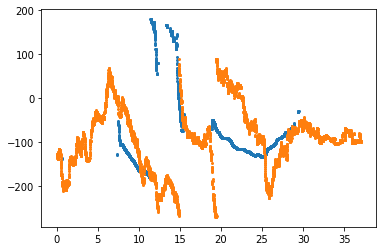

In [126]:
plt.plot(np.arange(0,len(mouse_az))/200,mouse_az, linestyle='', marker='o', markersize=2)
plt.plot(np.arange(0,len(head_az))/200,head_az, linestyle='', marker='o', markersize=2)

In [39]:
mouse_xy, cricket_p, cricket_xy, rear_xy, lear_xy, headbase_xy=extract_points(file, ['Rear','Lear', 'anteriorC', 'posteriorC','headbase'])

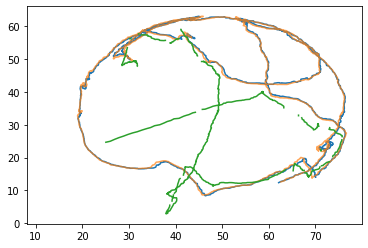

In [40]:
plt.plot(headbase_xy[0],headbase_xy[1])
plt.plot(mouse_xy[0],mouse_xy[1], alpha=0.7)
plt.plot(cricket_xy[0],cricket_xy[1])

In [13]:
    #mike has a different way of calculating azimuth, try that instead 
    #a=centerofmass to nose distance; b=center of mass to cricket distance, c=nose to to cricket distance
    #az=acosd(a^2+b^2-c^2)/2ab 
    a=np.sqrt(np.square((mouse_xy[0]-headbase_xy[0]))+np.square((mouse_xy[1]-headbase_xy[1])))
    b=np.sqrt(np.square((headbase_xy[0]-cricket_xy[0]))+np.square((headbase_xy[1]-cricket_xy[1])))
    c=np.sqrt(np.square((mouse_xy[0]-cricket_xy[0]))+np.square((mouse_xy[1]-cricket_xy[1])))
    new_az=np.arccos((np.square(a)+np.square(b)-np.square(c))/(2*a*b))

In [165]:
c=np.sqrt(np.square((mouse_xy[0]-cricket_xy[0]))+np.square((mouse_xy[1]-cricket_xy[1])))

In [166]:
b

array([nan, nan, nan, ..., nan, nan, nan])

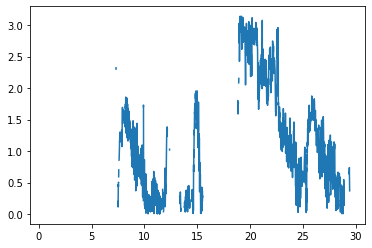

In [14]:
plt.plot(np.arange(0,len(new_az))/200,new_az)

In [15]:
new_az=(new_az*180)/np.pi

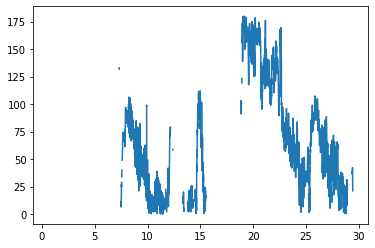

In [16]:
plt.plot(np.arange(0,len(new_az))/200,new_az)

In [18]:
from scipy import interpolate

In [23]:
if np.sum(~np.isnan(new_az))>0:
    azOld = new_az
    ind = np.arange(0,len(new_az))
    interp = interpolate.interp1d(ind[~np.isnan(new_az)], az[~np.isnan(new_az)],bounds_error=False, fill_value=np.nan )
    new_az = interp(ind)
    new_az=(new_az*180)/np.pi


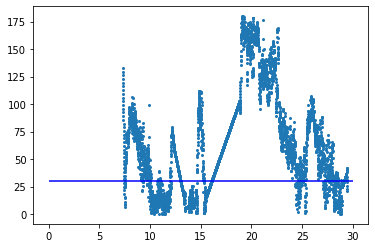

In [26]:
plt.plot(np.arange(0,len(new_az))/200,new_az,linestyle='', marker='o', markersize=2)
plt.hlines(y=30, xmin=0,xmax=6000/200, color='b')

In [70]:
import numpy as np
from numpy import linalg as la

def get_angle(centerpt, refpt, measurept):
    '''
    Function to get any angle you want.

    Args:
        centerpt (:class:`numpy.ndarray`) : nx2 array, position of center point 
            of your choice, i.e. midpoint of ears, back of head.
        refpt (:class:`numpy.ndarray`) : nx2 array, position of reference point 
            of your choice, i.e. the nose in this case.
        measurept (:class:`numpy.ndarray`) : nx2 array, position of the cricket.

    Returns:
        angle (:class:`numpy.ndarray`): nx1 array of angles across time
    '''

    #match lenght of arbitrary points chosen for ref or center point 
    # maxmeasure=np.max()

    #calculate the normalized vectors for getting the angle  
    n1=(measurept-centerpt)/la.norm((measurept-centerpt))
    n2=(refpt-centerpt)/la.norm((refpt-centerpt))

    #use arctan to get the angle at every point in time
    angle=np.empty([maxmeasure,1], dtype=float)
    print(angle)
    maxmeasure=4
    
    counter=0
    for i in range(0,maxmeasure):
        angle[i,:] = np.arctan2(la.norm(la.det((n2[i,:], n1[i,:]))), np.dot(n1[i,:], n2[i,:]))
        counter +=1
    print(angle)
    return angle

In [71]:
angle=get_angle(np.array([[0,0],[0,0],[0,0],[0,0]]),np.array([[0,1],[0,1],[0,1],[0,1]]),np.array([[1,0],[1,1],[0,1],[0,1]]))

[[1 0]
 [1 1]
 [0 1]
 [0 1]]
2.23606797749979
[[0.4472136 0.       ]
 [0.4472136 0.4472136]
 [0.        0.4472136]
 [0.        0.4472136]]
[[0.  0.5]
 [0.  0.5]
 [0.  0.5]
 [0.  0.5]]


In [52]:
print(angle)

[[1.57079633]
 [0.78539816]
 [0.        ]
 [0.        ]]


In [87]:
centerpt=np.array([[0,0],[0,0]])
# refpt=np.asarray([0,1],[0,1])
# measurept=np.asarray([1,0],[1,1])
centerpt

array([[0, 0],
       [0, 0]])

In [149]:
maxmeasure=2
len(range(0,maxmeasure))


2

In [46]:
n1=(measurept-centerpt)/la.norm((measurept-centerpt))
n2=(refpt-centerpt)/la.norm((refpt-centerpt))

NameError: name 'measurept' is not defined

In [39]:
type(n1[0])

numpy.float64

In [50]:
la.norm(la.det((n2[:], n1[:])))

1.0

In [54]:
np.dot(n1[:], n2[:])

0.0

In [61]:
i=0

In [62]:
angle = np.arctan2(la.norm(la.det((n2[i], n1[i]))), np.dot(n1[i], n2[i]))

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

In [59]:
angle

1.5707963267948966

In [45]:
approach, captureT, freqapproach, timetoapproach, timetointercept, prob_inter, prob_capture =preycap_metrics(cricket_xy, cricket_p, dist, mouse_spd, az,oldmodel=False)

150.085
1324
27956
26632
133.16
(array([  204,  1049,  1488,  2027,  4776, 10235, 10365, 11468, 16071,
       17085, 25633, 25962, 26330]),)
(array([  352,  1143,  1712,  2105,  4864, 10270, 10506, 11612, 16154,
       17304, 25738, 26045]),)
[ 8.18177379  3.5695     20.73107362 26.99378546 36.27242237 13.65579495
  2.91889785 18.99781363 43.00696534 12.30588543 14.19380143  6.5852565 ]
6.585256497473586
no capture


In [46]:
26630/200

133.15

In [131]:
25006/200

125.03

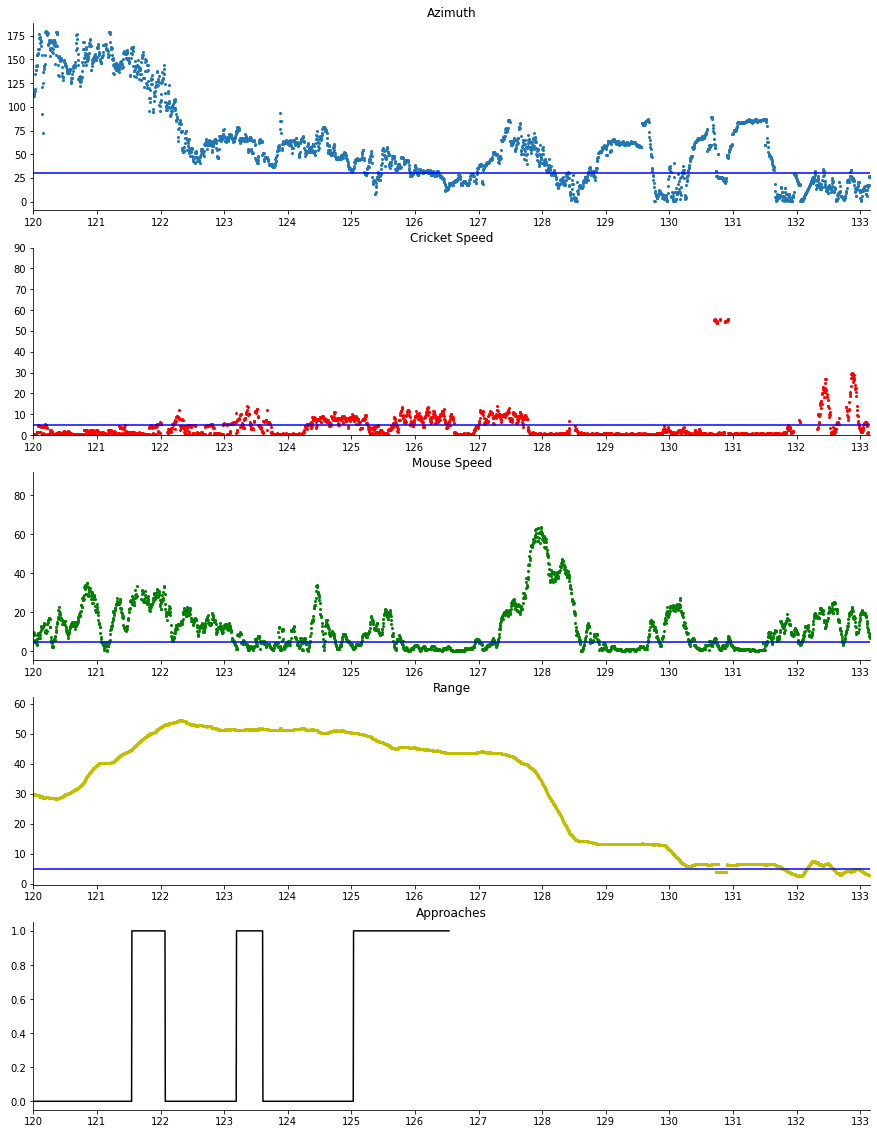

In [139]:
fr=200
fig=plt.figure(figsize=(15,20))
ax1,ax2,ax3,ax4, ax5=fig.subplots(5,1)
ax1.plot(np.arange(0,len(az))/200,az, linestyle='', marker='o', markersize=2)
ax1.hlines(y=30, xmin=0,xmax=len(az)/fr, color='b')
ax1.set_title('Azimuth')
ax1.set_xlim(120,len(az)/fr)
ax1.set_xticks(np.arange(120,len(az)/fr,1))

# ax1.hlines(y=-30, xmin=0,xmax=6000/200,color='b')
ax2.plot(np.arange(0,len(cricket_spd))/200,cricket_spd, linestyle='', marker='o', markersize=2, color='r')
ax2.hlines(y=5, xmin=0,xmax=len(cricket_spd)/fr,color='b')
ax2.set_title('Cricket Speed')
ax2.set_ylim(0,90)
ax2.set_xlim(120,len(cricket_spd)/fr)
ax2.set_xticks(np.arange(120,len(cricket_spd)/fr,1))

ax3.plot(np.arange(0,len(mouse_spd))/200,mouse_spd, linestyle='', marker='o', markersize=2, color='g')
ax3.hlines(y=5, xmin=0,xmax=len(mouse_spd)/fr,color='b')
ax3.set_title('Mouse Speed')
ax3.set_xlim(120,len(mouse_spd)/fr)
ax3.set_xticks(np.arange(120,len(mouse_spd)/fr,1))

ax4.plot(np.arange(0,len(dist))/fr,dist, linestyle='', marker='o', markersize=2, color='y')
ax4.set_title('Range')
ax4.hlines(y=5, xmin=0,xmax=len(dist)/fr,color='b')
ax4.set_xlim(120,len(dist)/fr)
ax4.set_xticks(np.arange(120,len(dist)/fr,1))
# ax3.set_xlim(6,25)

ax5.plot(np.arange(0,len(approach))/fr,approach, color='black')
ax5.set_title('Approaches')
ax5.set_xlim(120,len(dist)/fr)
ax5.set_xticks(np.arange(120,len(dist)/fr,1))
sns.despine()

In [33]:
newthresh=0.9
fr=200
oldmodel=False
movieT=len(cricket_p)/fr
if oldmodel==True:
    start2end=np.where(cricket_p>newthresh)[0]
    captureT=(start2end[-1]-start2end[0])/fr
else:
    df = pd.DataFrame({'data':cricket_p})
    periods = relentless_positivity(df, 'data')
    start=np.min(periods)
    # print(start)
    end=np.max(periods)
    # print(end)
    captureT=(end-start)/fr
if captureT.size==0:
    captureT=movieT

In [34]:
#calculate latency and frequency of initiating approaches
approach = []
paired = list(zip(az[start:end],mouse_spd[start:end]))
for pair in paired:
    if np.abs(pair[0]) < 30 and pair[1] > 5:
        approach.append(1)
    else:
        approach.append(0)

approach = signal.medfilt(approach, 101) # 101 is hardcoded half a second based on framerate
approach = np.asarray(approach)
#plt.plot(approach)

approachStarts = np.where(np.diff(approach)>0)
approachEnds = np.where(np.diff(approach)<0)
#print(approachEnds)
firstApproach = np.min(approachStarts)
timetoapproach = firstApproach/fr # return this
freqapproach=np.size(approachStarts) / movieT # return this

#calculate probability of interception given approach, and probability of capture given interception
#getting closer, still think there is something off about the distance calculation leading to fewer interceptions
#maybe something off with pix2cm converstion
intercept = []
maybeIntercept = np.take(range[start:end], approachEnds) # uses approachEnds to index range
maybeIntercept = maybeIntercept[0] # np.take returns tuple, first value are the ones you one
#print(maybeIntercept)
maybeIntercept[-1] = 0 # assuming last approach is intercept/capture, makes things werk, this needs to be changed, last intercept might not be a capture

for i in maybeIntercept:
    if i < 5:
        intercept.append(1)
    else:
        intercept.append(0)

TypeError: 'type' object is not subscriptable